#Preprocess

In [1]:
!pip install contractions emoji transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.7 MB/s eta 0:00:00


In [ ]:
# %%
import pandas as pd
import contractions
import emoji
from transformers import DistilBertTokenizerFast

# %%
# Tokenization with DistilBERT
def distilbert_tokenize(text):
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    return tokenizer(
        text,
        padding="max_length",     # pad all sequences to max length
        truncation=True,          # truncate sequences that are too long
        return_tensors=None       # keep outputs as lists
    )

# %%
# Clean and tokenize tweets
def preprocess_internal(df,
               tokenize,  # tokenizer function
               to_lower=True,
               remove_urls=True,
               remove_emojis=True,
               remove_contractions=True,
               remove_punctuation=True):
    print("Preprocessing started")
    if df is None or df.empty:
        return None

    df['text_cleaned'] = df['text'].copy()
    if to_lower:
        df['text_cleaned'] = df['text_cleaned'].str.lower()
    if remove_urls:
        df['text_cleaned'] = df['text_cleaned'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    if remove_emojis:
        df['text_cleaned'] = df['text_cleaned'].apply(lambda x: emoji.demojize(x))
    if remove_contractions:
        df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x))
    if remove_punctuation:
        df['text_cleaned'] = df['text_cleaned'].str.replace(r'[^\w\s\']', '', regex=True)

    encoded_outputs = tokenize(df['text_cleaned'].tolist())
    df["input_ids"] = encoded_outputs["input_ids"]
    df["attention_mask"] = encoded_outputs["attention_mask"]

    # DistilBERT does not use token_type_ids
    result_df = df[["id", "user", "date", "text", "text_cleaned", "input_ids", "attention_mask", "target"]]
    return result_df

# %%
# Load and process the dataset
def load_and_preprocess_sentiment140(csv_path, sample_per_class=100_000):
    print("Loading dataset...")
    columns = ['target', 'id', 'date', 'query', 'user', 'text']
    df = pd.read_csv(csv_path, encoding='latin-1', names=columns)

    # Convert sentiment labels: 0=neg, 2=neutral, 4=pos → 0,1,2
    df['target'] = df['target'].replace({0: 0, 2: 1, 4: 2})

    # Drop unnecessary columns early
    df = df[['target', 'id', 'date', 'user', 'text']]

    # Balance dataset
    df_balanced = df.groupby('target').apply(lambda x: x.sample(sample_per_class, random_state=42)).reset_index(drop=True)
    print(f"Sampled {sample_per_class} tweets per class.")

    # Preprocess and tokenize
    processed_df = preprocess_internal(df_balanced, distilbert_tokenize)
    print("Preprocessing complete.")

    return processed_df


#Load the Training Data

In [ ]:
# Now preprocess the local file
csv_path = "training.1600000.processed.noemoticon.csv"  # adjust if saved somewhere else

processed_df = load_and_preprocess_sentiment140(csv_path, sample_per_class=25000)

# Preview the processed data
print(processed_df.head())

Loading dataset...


<ipython-input-2-c3b4c2eb07f5>:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('target').apply(lambda x: x.sample(sample_per_class, random_state=42)).reset_index(drop=True)


Sampled 25000 tweets per class.
Preprocessing started


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Preprocessing complete.
           id            user                          date  \
0  1974671194         simba98  Sat May 30 13:36:31 PDT 2009   
1  1997882236          Seve76  Mon Jun 01 17:37:11 PDT 2009   
2  2177756662  x__claireyy__x  Mon Jun 15 06:39:05 PDT 2009   
3  2216838047          Balasi  Wed Jun 17 20:02:12 PDT 2009   
4  1880666283    djrickdawson  Fri May 22 02:03:31 PDT 2009   

                                                text  \
0  @xnausikaax oh no! where did u order from? tha...   
1  A great hard training weekend is over.  a coup...   
2  Right, off to work  Only 5 hours to go until I...   
3                    I am craving for japanese food    
4  Jean Michel Jarre concert tomorrow  gotta work...   

                                        text_cleaned  \
0  xnausikaax oh no where did you order from that...   
1  a great hard training weekend is over  a coupl...   
2  right off to work  only 5 hours to go until i ...   
3                    i am craving fo

# Convert Preprocessed Data into a PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class Sentiment140Dataset(Dataset):
    def __init__(self, df):
        self.df = df
        # Convert columns to tensors and store as lists
        self.input_ids = df["input_ids"].apply(torch.tensor).tolist()
        self.attention_mask = df["attention_mask"].apply(torch.tensor).tolist()
        self.labels = df["target"].apply(torch.tensor).tolist() # Changed from "target" to "labels"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

#Create Dataloaders

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split and reset index
train_df, val_df = train_test_split(processed_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Convert to PyTorch Datasets
train_dataset = Sentiment140Dataset(train_df)
val_dataset = Sentiment140Dataset(val_df)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

#Set Up the Model for Fine-Tuning

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Load the pre-trained DistilBERT model with 3 output labels (for sentiment)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Specify training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Output directory for saved models
    evaluation_strategy="epoch",         # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    num_train_epochs=3,                  # Number of epochs
    weight_decay=0.01,                   # Weight decay for regularization
    logging_dir='./logs',                # Directory for logs
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Initialize the Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


#Train and Evaluate the Model

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

print("Evaluation Results:")
print(eval_results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.410200,0.413644,0.811500,0.817420,0.811500,0.810543
2,0.326000,0.400517,0.819900,0.820154,0.819900,0.819849
3,0.244700,0.496174,0.818400,0.818785,0.818400,0.818327


Evaluation Results:
{'eval_loss': 0.49617430567741394, 'eval_accuracy': 0.8184, 'eval_precision': 0.8187845085394578, 'eval_recall': 0.8184, 'eval_f1': 0.8183267421221272, 'eval_runtime': 149.061, 'eval_samples_per_second': 67.087, 'eval_steps_per_second': 4.193, 'epoch': 3.0}


#Save the Model

In [ ]:
model.save_pretrained('./sentiment140_distilbert_model2')

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
tokenizer.save_pretrained("./sentiment140_distilbert_model2")


('./sentiment140_distilbert_model2/tokenizer_config.json',
 './sentiment140_distilbert_model2/special_tokens_map.json',
 './sentiment140_distilbert_model2/vocab.txt',
 './sentiment140_distilbert_model2/added_tokens.json',
 './sentiment140_distilbert_model2/tokenizer.json')

In [ ]:
!zip -r sentiment140_distilbert_model2.zip sentiment140_distilbert_model2

from google.colab import files
files.download("sentiment140_distilbert_model2.zip")

updating: sentiment140_distilbert_model2/ (stored 0%)
updating: sentiment140_distilbert_model2/config.json (deflated 49%)
updating: sentiment140_distilbert_model2/vocab.txt (deflated 53%)
updating: sentiment140_distilbert_model2/model.safetensors (deflated 8%)
updating: sentiment140_distilbert_model2/tokenizer.json (deflated 71%)
updating: sentiment140_distilbert_model2/tokenizer_config.json (deflated 75%)
updating: sentiment140_distilbert_model2/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Load Test Data

In [2]:
!git clone https://github.com/YupengHuangFrank/ECE1513.git

Cloning into 'ECE1513'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 239 (delta 17), reused 222 (delta 8), pack-reused 7 (from 2)
Receiving objects: 100% (239/239), 58.11 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Filtering content: 100% (195/195), 12.64 GiB | 47.76 MiB/s, done.


#Load the Model

In [6]:
!unzip sentiment140_distilbert_model2.zip

Archive:  sentiment140_distilbert_model2.zip
  inflating: sentiment140_distilbert_model2/config.json  
  inflating: sentiment140_distilbert_model2/vocab.txt  
  inflating: sentiment140_distilbert_model2/model.safetensors  
  inflating: sentiment140_distilbert_model2/tokenizer.json  
  inflating: sentiment140_distilbert_model2/tokenizer_config.json  
  inflating: sentiment140_distilbert_model2/special_tokens_map.json  


In [13]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and tokenizer from nested folder
model_path = "sentiment140_distilbert_model2/sentiment140_distilbert_model2"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

Using device: cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#Process Test Data and Predict Sentiment for Tweets about Kamala Harris, Donald Trump or Joe Biden

In [14]:
import os
import pandas as pd
from pathlib import Path
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.nn.functional import softmax
import contractions
import emoji
import re
from tqdm import tqdm

# Prevent CUDA fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


# Define politician keywords
politicians = {
    "joe biden": ["joe biden", "biden", "@joebiden"],
    "kamala harris": ["kamala harris", "kamala", "@kamalaharris"],
    "donald trump": ["donald trump", "trump", "@realdonaldtrump"]
}

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = emoji.demojize(text)
    text = contractions.fix(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s\']', '', text)
    return text

# Inference batching function
def batch_infer(texts, tokenizer, model, batch_size=32, device="cuda"):
    results = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            tokens = {k: v.to(device) for k, v in tokens.items()}
            outputs = model(**tokens)
            probs = softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            results.extend(preds.cpu().tolist())
            torch.cuda.empty_cache()
    return results

# Path to date-ordered tweet files
data_path = Path("ECE1513/Date-Ordered-Data")
all_files = sorted(data_path.glob("*.csv.gz"))

# Store all predictions
all_results = []

for file in tqdm(all_files, desc="Processing files"):
    try:
        date_str = file.stem
        df = pd.read_csv(file, compression='gzip', usecols=['text'], low_memory=False)
        df = df[df['text'].notna()].sample(n=min(1000, len(df)), random_state=42)
        df["text_cleaned"] = df["text"].astype(str).apply(clean_text)

        for politician, keywords in politicians.items():
            mask = df["text_cleaned"].apply(lambda t: any(k in t for k in keywords))
            df_filtered = df[mask].copy()
            if df_filtered.empty:
                continue

            texts = df_filtered["text_cleaned"].tolist()
            preds = batch_infer(texts, tokenizer, model, batch_size=32, device=device)

            df_filtered["predicted_label"] = preds
            df_filtered["sentiment"] = df_filtered["predicted_label"].map({0: "negative", 1: "neutral", 2: "positive"})
            df_filtered["date"] = date_str
            df_filtered["politician"] = politician

            all_results.append(df_filtered[["date", "politician", "sentiment"]])

            # Memory cleanup
            del df_filtered, texts, preds
            torch.cuda.empty_cache()

        del df
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error processing {file.name}: {e}")


Processing files: 100%|██████████| 195/195 [22:55<00:00,  7.06s/it]


#Combine and Aggregate Results

In [16]:
# Combine all predictions into one DataFrame
final_df = pd.concat(all_results, ignore_index=True)

# Save raw predictions if needed
final_df.to_csv("predicted_sentiments.csv", index=False)

# Aggregate sentiment counts per day per politician
agg_df = final_df.groupby(["date", "politician", "sentiment"]).size().unstack(fill_value=0).reset_index()
agg_df.to_csv("aggregated_sentiment_trends.csv", index=False)

# Preview
agg_df


sentiment,date,politician,negative,positive
0,2024-05-01.csv,donald trump,141,165
1,2024-05-01.csv,joe biden,399,423
2,2024-05-01.csv,kamala harris,5,6
3,2024-05-02.csv,donald trump,137,162
4,2024-05-02.csv,joe biden,404,422
...,...,...,...,...
576,2024-11-29.csv,joe biden,139,115
577,2024-11-29.csv,kamala harris,33,20
578,2024-11-30.csv,donald trump,90,114
579,2024-11-30.csv,joe biden,107,131


#Plot Sentiment Over Time for Each Candidate

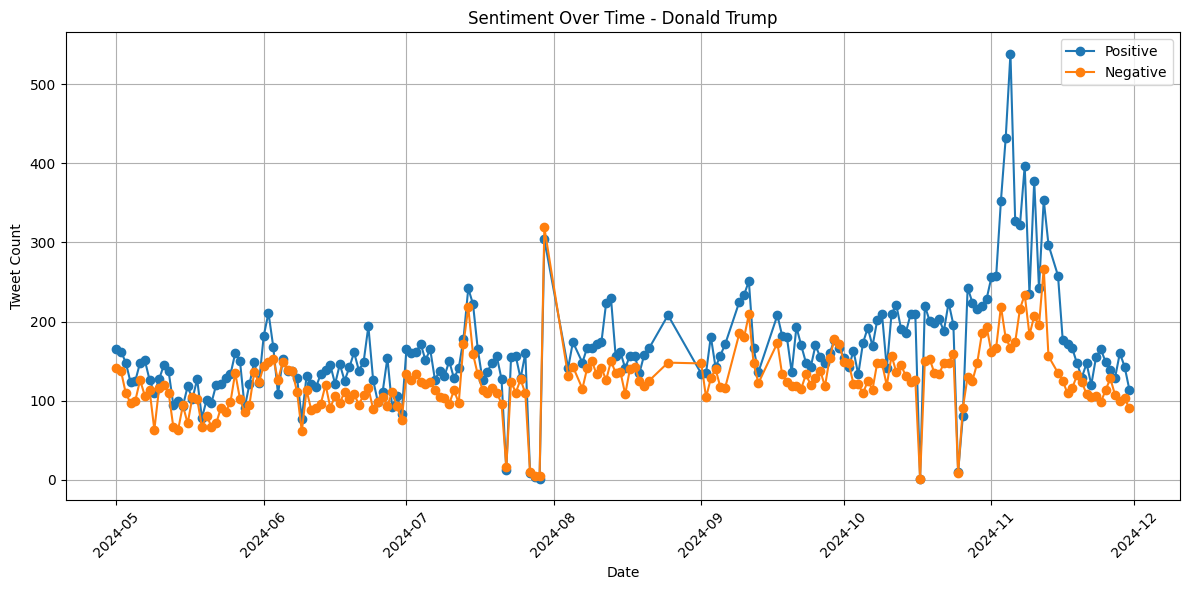

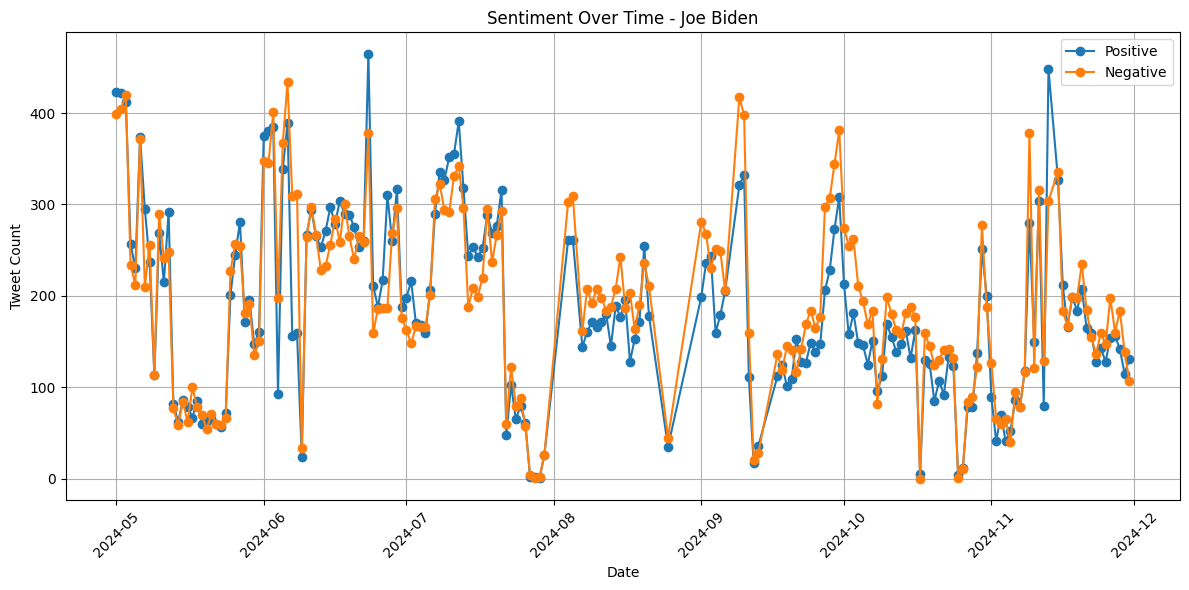

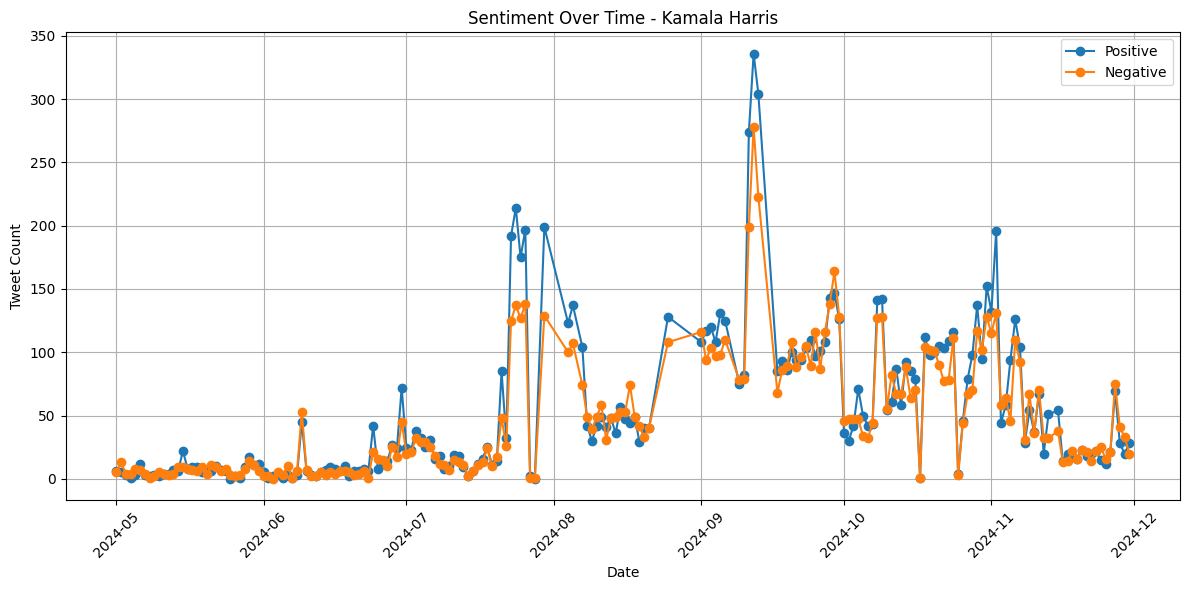

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the aggregated sentiment data
agg_df = pd.read_csv("aggregated_sentiment_trends.csv")

# Strip `.csv` or `.csv.gz` from date values
agg_df["date"] = agg_df["date"].str.replace(".csv.gz", "", regex=False).str.replace(".csv", "", regex=False)

# Then convert to datetime
agg_df["date"] = pd.to_datetime(agg_df["date"], format="%Y-%m-%d")

# Sort the data
agg_df = agg_df.sort_values("date")

# Plot sentiment over time for each candidate
politicians = agg_df["politician"].unique()

for politician in politicians:
    candidate_df = agg_df[agg_df["politician"] == politician]

    plt.figure(figsize=(12, 6))
    plt.plot(candidate_df["date"], candidate_df.get("positive", 0), label="Positive", marker='o')

    plt.plot(candidate_df["date"], candidate_df.get("negative", 0), label="Negative", marker='o')

    plt.title(f"Sentiment Over Time - {politician.title()}")
    plt.xlabel("Date")
    plt.ylabel("Tweet Count")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Sample 8000 tweets per day

In [25]:
import os
import pandas as pd
from pathlib import Path
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.nn.functional import softmax
import contractions
import emoji
import re
from tqdm import tqdm

# Prevent CUDA fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


# Define politician keywords
politicians = {
    "joe biden": ["joe biden", "biden", "@joebiden"],
    "kamala harris": ["kamala harris", "kamala", "@kamalaharris"],
    "donald trump": ["donald trump", "trump", "@realdonaldtrump"]
}

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = emoji.demojize(text)
    text = contractions.fix(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s\']', '', text)
    return text

# Inference batching function
def batch_infer(texts, tokenizer, model, batch_size=32, device="cuda"):
    results = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            tokens = {k: v.to(device) for k, v in tokens.items()}
            outputs = model(**tokens)
            probs = softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            results.extend(preds.cpu().tolist())
            torch.cuda.empty_cache()
    return results

# Path to date-ordered tweet files
data_path = Path("ECE1513/Date-Ordered-Data")
all_files = sorted(data_path.glob("*.csv.gz"))

# Store all predictions
all_results = []

for file in tqdm(all_files, desc="Processing files"):
    try:
        date_str = file.stem
        df = pd.read_csv(file, compression='gzip', usecols=['text'], low_memory=False)
        df = df[df['text'].notna()].sample(n=min(8000, len(df)), random_state=42)
        df["text_cleaned"] = df["text"].astype(str).apply(clean_text)

        for politician, keywords in politicians.items():
            mask = df["text_cleaned"].apply(lambda t: any(k in t for k in keywords))
            df_filtered = df[mask].copy()
            if df_filtered.empty:
                continue

            texts = df_filtered["text_cleaned"].tolist()
            preds = batch_infer(texts, tokenizer, model, batch_size=32, device=device)

            df_filtered["predicted_label"] = preds
            df_filtered["sentiment"] = df_filtered["predicted_label"].map({0: "negative", 1: "neutral", 2: "positive"})
            df_filtered["date"] = date_str
            df_filtered["politician"] = politician

            all_results.append(df_filtered[["date", "politician", "sentiment"]])

            # Memory cleanup
            del df_filtered, texts, preds
            torch.cuda.empty_cache()

        del df
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error processing {file.name}: {e}")


Processing files: 100%|██████████| 195/195 [1:15:24<00:00, 23.20s/it]


In [ ]:
# Combine all predictions into one DataFrame
final_df = pd.concat(all_results, ignore_index=True)

# Save raw predictions if needed
final_df.to_csv("predicted_sentiments8000.csv", index=False)

#Plot Sentiment Over TIme for 8000 tweets/day

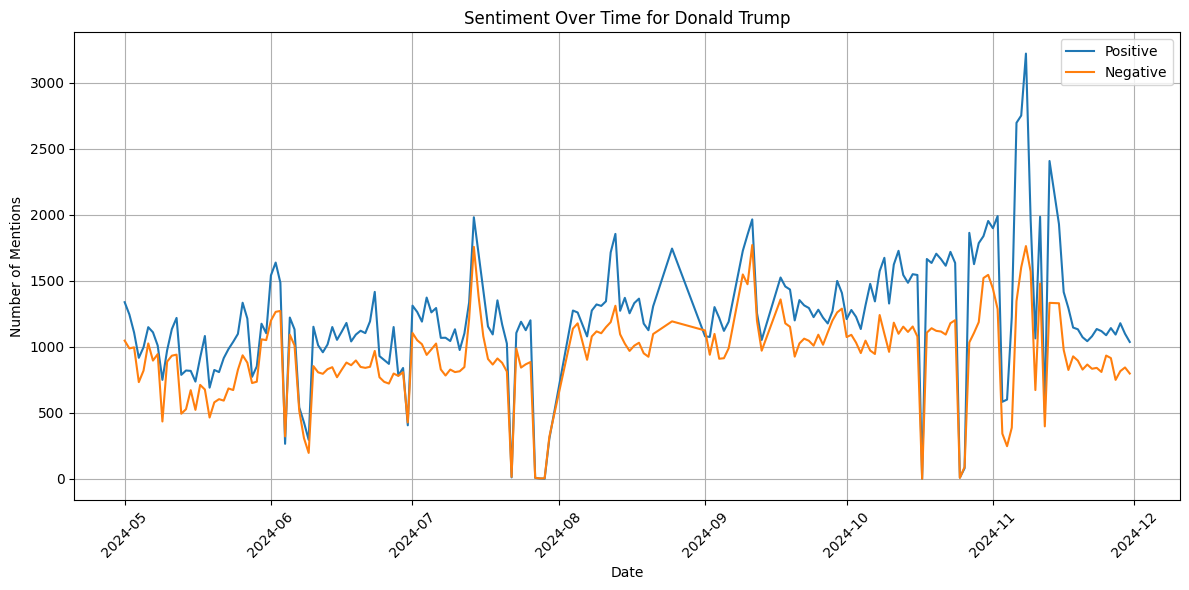

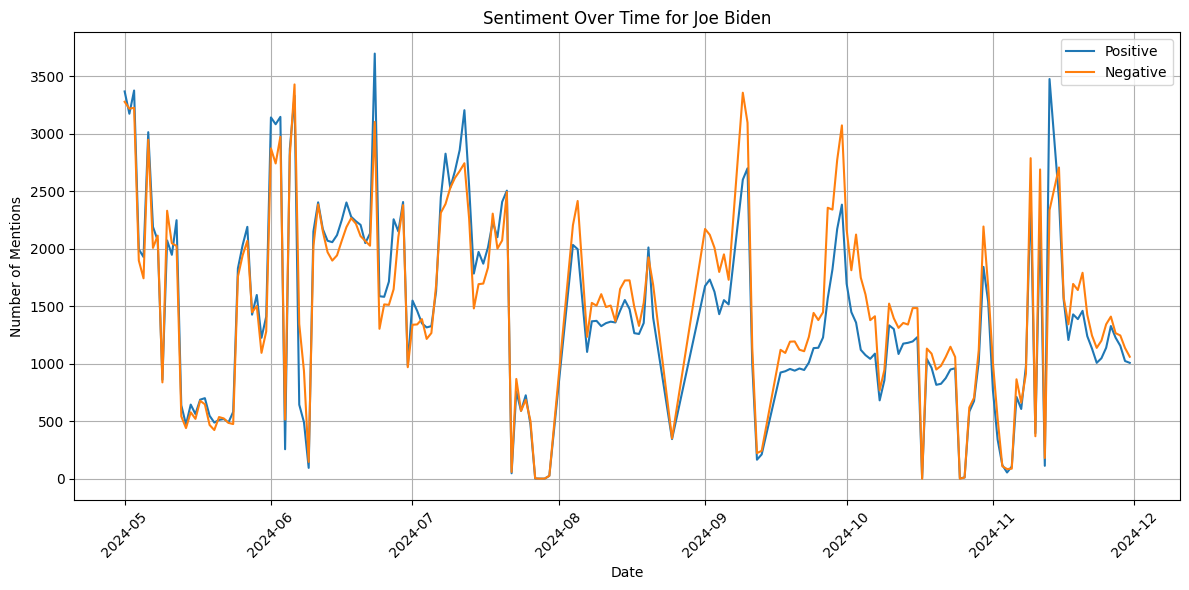

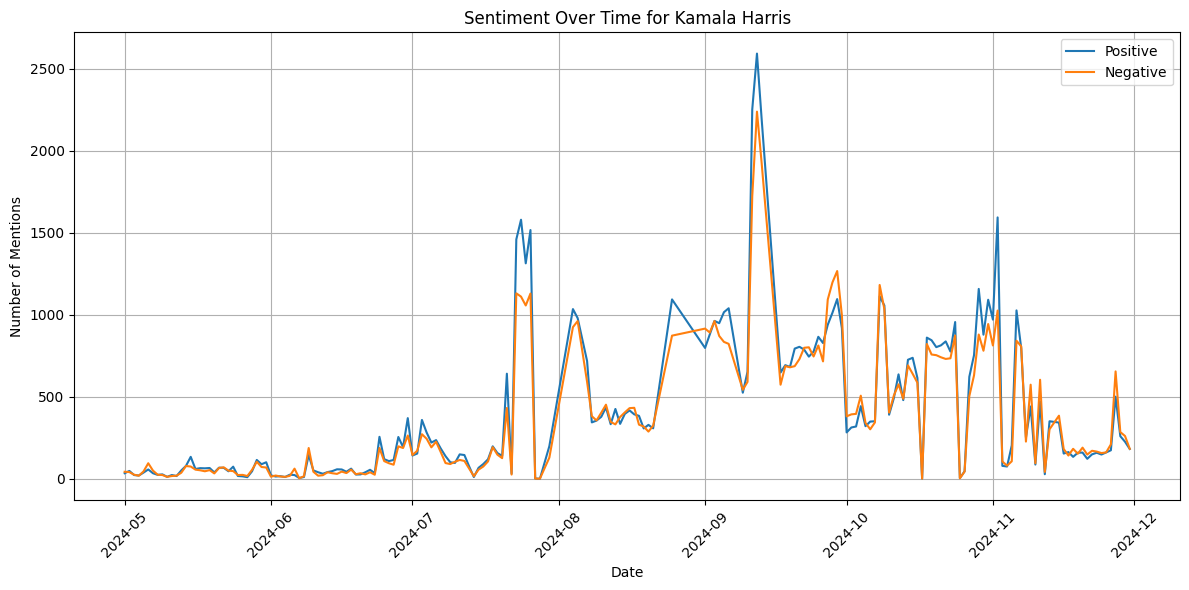

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv("predicted_sentiments8000.csv")

# Clean the 'date' column: remove '.csv' extension and convert to datetime
df['date'] = pd.to_datetime(df['date'].astype(str).str.replace('.csv', '', regex=False))

# Group by date, politician, and sentiment, then count entries
sentiment_counts = df.groupby(['date', 'politician', 'sentiment']).size().unstack(fill_value=0).reset_index()

# Plot sentiment over time for each politician
politicians = sentiment_counts['politician'].unique()

for pol in politicians:
    pol_data = sentiment_counts[sentiment_counts['politician'] == pol]

    plt.figure(figsize=(12, 6))
    if 'positive' in pol_data.columns:
        plt.plot(pol_data['date'], pol_data['positive'], label='Positive')
    if 'negative' in pol_data.columns:
        plt.plot(pol_data['date'], pol_data['negative'], label='Negative')

    plt.title(f"Sentiment Over Time for {pol.title()}")
    plt.xlabel("Date")
    plt.ylabel("Number of Mentions")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#Further Sentiment Analysis

In [17]:
# === 1. Sentiment Distribution by Politician ===
sentiment_dist = df.groupby(['politician', 'sentiment']).size().unstack(fill_value=0)

# Add a sentiment score (positive - negative)
sentiment_dist['score'] = sentiment_dist.get('positive', 0) - sentiment_dist.get('negative', 0)

print("\n=== Sentiment Distribution by Politician ===")
print(sentiment_dist)

# === 2. Sentiment Score Per Day ===
daily_sentiment = df.groupby(['date', 'politician', 'sentiment']).size().unstack(fill_value=0).reset_index()
daily_sentiment['score'] = daily_sentiment.get('positive', 0) - daily_sentiment.get('negative', 0)

# === 3. Most Positive Days (Top 10) ===
top_positive_days = (
    daily_sentiment.sort_values(['politician', 'score'], ascending=[True, False])
    .groupby('politician')
    .head(10)
    .reset_index(drop=True)
)
print("\n=== Top 10 Most Positive Days by Politician ===")
print(top_positive_days[['date', 'politician', 'positive', 'negative', 'score']])

# === 4. Least Positive Days (Bottom 10) ===
bottom_positive_days = (
    daily_sentiment.sort_values(['politician', 'score'], ascending=[True, True])
    .groupby('politician')
    .head(10)
    .reset_index(drop=True)
)
print("\n=== Top 10 Least Positive (Most Negative) Days by Politician ===")
print(bottom_positive_days[['date', 'politician', 'positive', 'negative', 'score']])


=== Sentiment Distribution by Politician ===
sentiment      negative  positive  score
politician                              
donald trump     180776    235840  55064
joe biden        293186    279886 -13300
kamala harris     70989     76741   5752

=== Top 10 Most Positive Days by Politician ===
sentiment       date     politician  positive  negative  score
0         2024-11-08   donald trump      3220      1763   1457
1         2024-11-06   donald trump      2696      1346   1350
2         2024-11-07   donald trump      2751      1602   1149
3         2024-11-13   donald trump      2407      1333   1074
4         2024-11-05   donald trump      1225       388    837
5         2024-10-27   donald trump      1863      1033    830
6         2024-11-02   donald trump      1990      1286    704
7         2024-10-12   donald trump      1727      1099    628
8         2024-11-15   donald trump      1929      1330    599
9         2024-10-29   donald trump      1785      1187    598
10     

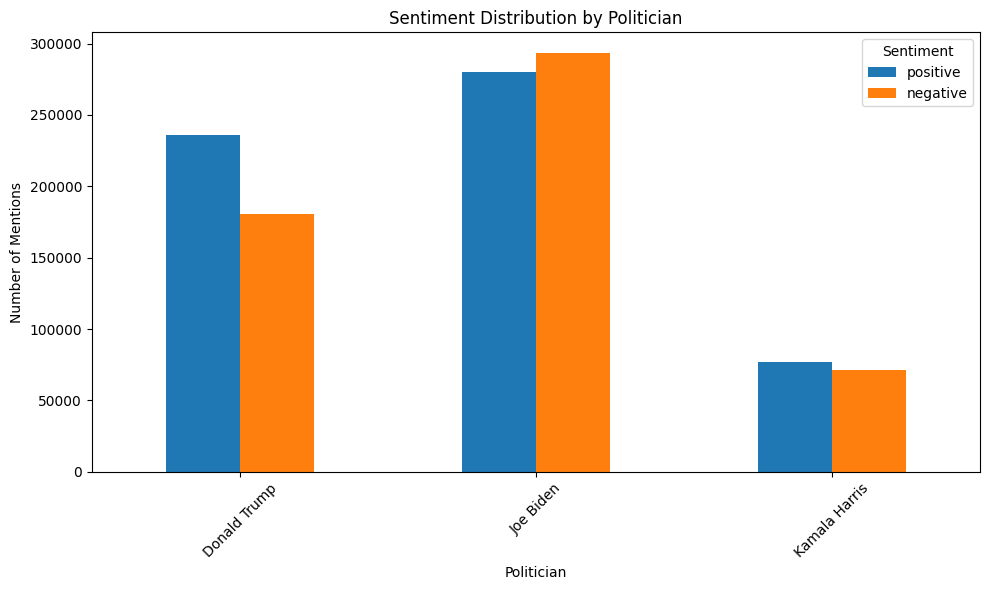

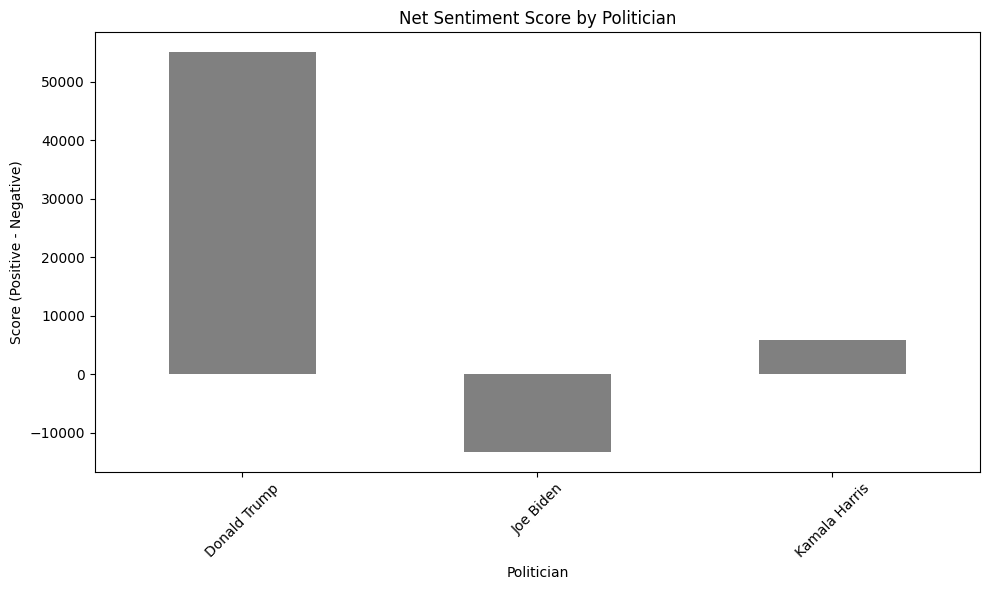

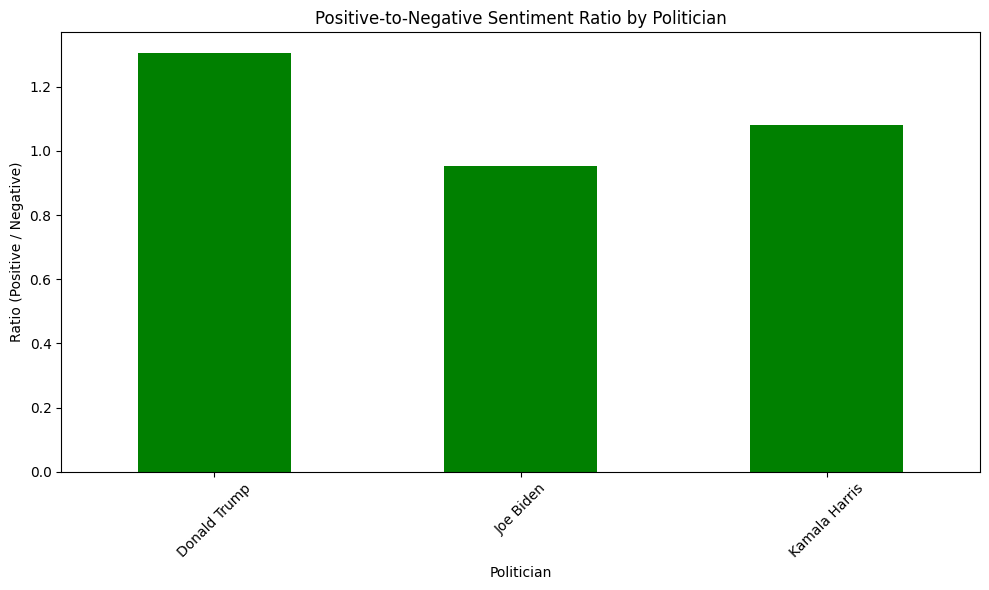

In [18]:
# === Sentiment Ratio (Positive / Negative) ===
sentiment_dist['ratio'] = (sentiment_dist['positive'] / sentiment_dist['negative'].replace(0, pd.NA)).fillna(0)

# === Visualization 1: Sentiment Distribution ===
sentiment_dist[['positive', 'negative']].plot(kind='bar', figsize=(10, 6))
plt.title("Sentiment Distribution by Politician")
plt.xlabel("Politician")
plt.ylabel("Number of Mentions")
plt.xticks(ticks=range(len(sentiment_dist.index)), labels=sentiment_dist.index.str.title(), rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# === Visualization 2: Sentiment Score ===
sentiment_dist['score'].plot(kind='bar', figsize=(10, 6), color='gray')
plt.title("Net Sentiment Score by Politician")
plt.xlabel("Politician")
plt.ylabel("Score (Positive - Negative)")
plt.xticks(ticks=range(len(sentiment_dist.index)), labels=sentiment_dist.index.str.title(), rotation=45)
plt.tight_layout()
plt.show()

# === Visualization 3: Sentiment Ratio ===
sentiment_dist['ratio'].plot(kind='bar', figsize=(10, 6), color='green')
plt.title("Positive-to-Negative Sentiment Ratio by Politician")
plt.xlabel("Politician")
plt.ylabel("Ratio (Positive / Negative)")
plt.xticks(ticks=range(len(sentiment_dist.index)), labels=sentiment_dist.index.str.title(), rotation=45)
plt.tight_layout()
plt.show()

In [19]:
print("Positive-to-Negative Sentiment Ratio by Politician")
print(sentiment_dist['ratio'])

Positive-to-Negative Sentiment Ratio by Politician
politician
donald trump     1.304598
joe biden        0.954636
kamala harris    1.081027
Name: ratio, dtype: float64
